# Building an Expected Goals Model for Shot-Event Data

By Jayanth Nair, A Springboard Capstone Project

***Introduction***

The following table contains statistics from a very famous (or rather infamous) game of football, obtained from Christoph Biermann's book Football Hackers. It describes the game with conventional statistical metrics. 

|                             | Team A | Team B |
|-----------------------------|:------:|:------:|
|          Possession         |   52%  |   48%  |
| Passes into the 18 yard box |   19   |   11   |
|           Crosses           |   22   |   10   |
|           Corners           |    7   |    5   |
|      Dangerous attacks      |   55   |   34   |
|         Tackles won         |    5   |    1   |
|          Lost balls         |   69   |   76   |
|            Shots            |   18   |   14   |
|       Shots on Target       |   13   |   12   |

Upon first look, most people would conclude that Team A ran out comfortable winners. However, in reality Team B were the winners by some margin. These statistics are from the 2014 World Cup semi-final between Brazil and Germany. Team B were Germany. They won by 7 goals to 1.

Following the footsteps of baseball (Moneyball and more recently, Astroball) and basketball (Daryl Morey and the Houston Rockets), football/soccer is now undergoing a 'statistical revolution'. New statistical metrics are being developed which can quantify game scenarios better, thereby refining game tactics and player recruitment.

***What is Expected Goals?***

One of the relatively ubiquitous 'new' statistical metrics is Expected Goals (xG). xG essentially quantifies the quality of a shot by the probability of that shot being a goal. Intuitively, we know that a shot taken from outside the box is much less likely to be a goal than one being taken near the goal line. xG is a mere quantification of this intuitiveness. Some examples are below:

![Alt Text](https://media.giphy.com/media/jaJkRgaIT6wLayz5V7/giphy.gif)

This belter from Benjamin Pavard in the 2018 World Cup from outside the box will have a lower xG, while the goal below by Barcelona will have a much higher xG

![Alt Text](https://media.giphy.com/media/zRqwfjscelwlO/giphy.gif)

***Why do we need xG?***

xG is an excellent predictor of how good a team is going forward, i.e attacking. The following is a snippet of the Premier League table on Nov 11, 2019 in descending order of points from Understat. (G is Goals scored and xG is, well, xG).

As you can see, the xG numbers match pretty well with the actual goals scored for each team, with some notable exceptions. Leicester City's attackers are ruthless in front of goal, outperforming their xG numbers significantly. Watford, Southampton and Manchester United on the other end seem to be underperforming as per their xG. 


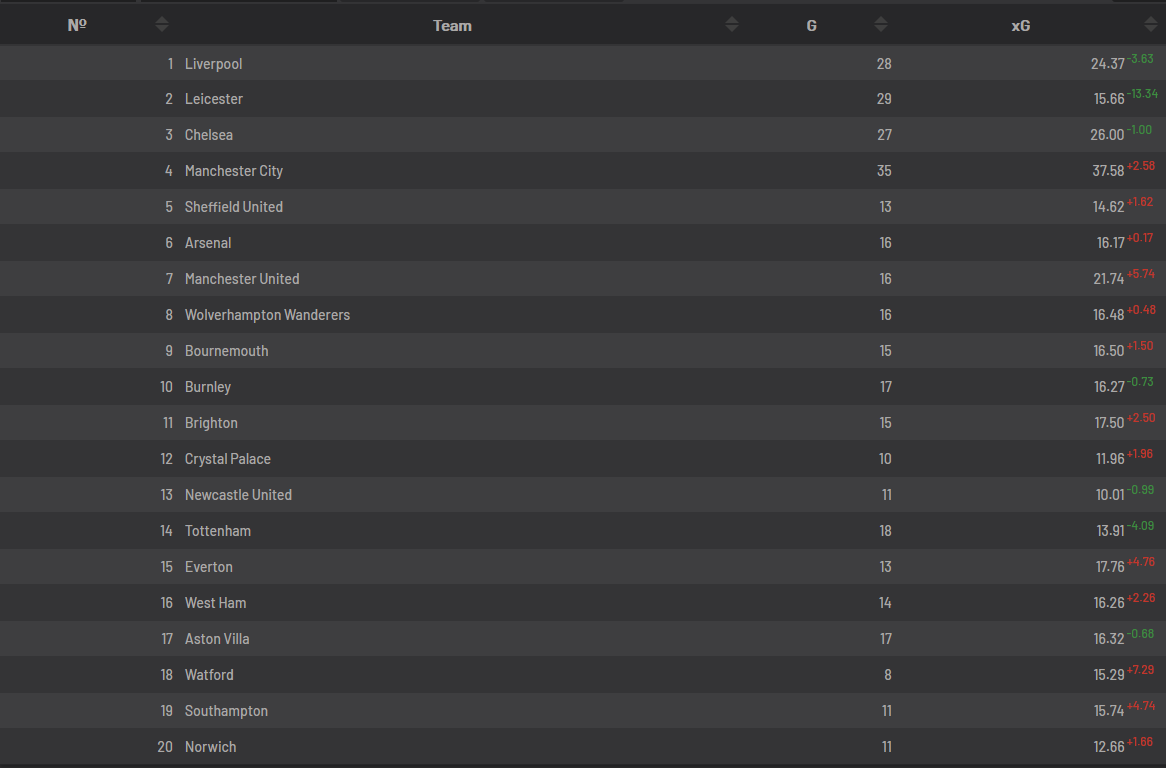

Similary expected goals against or xGA can be used to quantify the quality of shots a team faces.  This can be used as an indicator of how good a team's defense is. Below is a table of goals allowed and xGA. At the top end of the table, Leicester and Sheffield United (!!!) seem to be outperforming their xGA numbers while Chelsea seem to be struggling.  The bottom three are all struggling with their defenses leaking goals. 

Both Watford and Southampton were at the receiving end of 0-6 and 0-9 maulings this season, so that will skew their numbers a little.

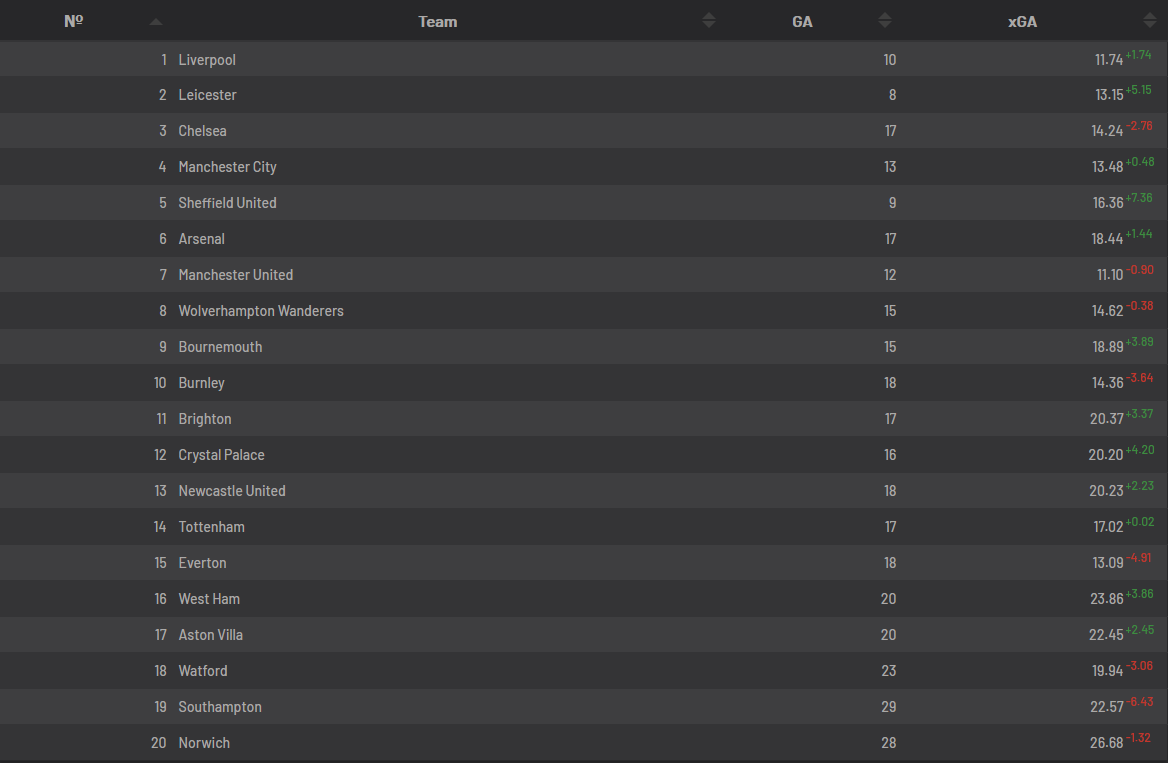

***Objective***

My objective with this project is to create my own xG model. The dataset I am using is the [Statsbomb open dataset](https://github.com/statsbomb/open-data). Specifically, I will be using the women's soccer dataset which contains data from 2 seasons of the FA WSL, 1 season of NWSL and the 2018 women's world cup

The data contains 229 games and 5929 shots which should be sufficient to build a workable xG model

The approach will be hypothesis-driven. In any hypothesis driven approach, there needs to be a hypothesis tree which drives the data wrangling and exploration.  The hypothesis tree for this project is given below:

![N|Solid](./decision_tree.png)

### Data Wrangling

### Step 1 - Importing the necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
%matplotlib inline
pd.options.display.max_columns = 15

The data from the Statsbomb dataset has been locally downloaded. So we direct the jupyter notebook to load the necessary data. Remember, the project will build a model based on women's soccer data. Thankfully, the Statsbomb have provided a detailed glossary and explanation of nomenclature to identify and extract the required data

In [2]:
#extracting information about which leagues
filepath = "D:\\statsbomb\\open-data-master\\data\\matches\\"
competitions =["37","49","72"]
league_list = []
for comp in competitions:
    path = filepath+comp
    league_list.extend(glob.glob(path+"\\*.json"))

In [3]:
#extracting match specific information
match_list=[]
home_list=[]
away_list=[]
for league in league_list:
    df=pd.read_json(league)
    match_list.extend(df['match_id'].values)
    for i in range(0,df.shape[0]):
        home_list.append(df['home_team'].values[i]['home_team_name'])
        away_list.append(df['away_team'].values[i]['away_team_name'])

Shot specific information which can be directly extracted from the data without further engineering are extracted first

In [4]:
eventspath = "D:\\statsbomb\\open-data-master\\data\\events\\"
shots_list=[] # all shots
loc_list=[] #all shot locations
timestamp_list=[] #time at which shot was taken
outcome_name_list = [] #all shot outcomes
outcome_id_list=[] #all shot outcome ids as per data
bodypart_name_list = [] #bodypart involved in shot
bodypart_id_list=[] #bodypart ids as per data
technique_name_list = [] #technique used in shot
technique_id_list=[] #technique ids as per data
type_name_list = [] #play pattern names
type_id_list=[] #play pattern ids
first_time_list=[] #whether shot was taken without a preceding touch 
statsbomb_xg_list = [] #statsbomb's xG prediction
key_pass_type_list=[] #the key pass leading up to the shot
player_list=[] #the player who took the shot
team_list=[] #the team the player belongs to
preceding_event_list=[]#the event preceding the shot
preceding_event_player_list=[]#the player involved in preceding event
preceding_event_team_list=[]#the team of the player involved

In [5]:
#extracting the above information
for match in match_list:
    matchname = str(match)
    path = eventspath+matchname+".json"
    df_events=pd.read_json(path)
    df_shots = df_events[['index','timestamp','shot','location','player','possession_team']].dropna()
    shots_list.append(df_shots.dropna().shape[0])
    loc_list.extend(list(df_shots['location'].values))
    timestamp_list.extend(list(df_shots['timestamp'].values))
    for i in range(0,len(df_shots)):
        outcome_name_list.append(df_shots.iloc[i][2]['outcome']['name'])
        outcome_id_list.append(df_shots.iloc[i][2]['outcome']['id'])
        bodypart_name_list.append(df_shots.iloc[i][2]['body_part']['name'])
        bodypart_id_list.append(df_shots.iloc[i][2]['body_part']['id'])
        technique_name_list.append(df_shots.iloc[i][2]['technique']['name'])
        technique_id_list.append(df_shots.iloc[i][2]['technique']['id'])
        type_name_list.append(df_shots.iloc[i][2]['type']['name'])
        type_id_list.append(df_shots.iloc[i][2]['type']['id'])
        player_list.append(df_shots.iloc[i][4]['name'])
        team_list.append(df_shots.iloc[i][5]['name'])
        
        #Whether a shot was a first time shot is indicated by a Boolean. Many shots are not first time shots
        #Error handling is used to not stop data extraction
        try:
            first_time_list.append(df_shots.iloc[i][2]['first_time'])
        except:
            first_time_list.append(False)
        
        #Many shots do not have a preceding key pass. Error handling is used in such cases
        try:
            key_pass = df_shots.iloc[i][2]['key_pass_id']
            filt1 = df_events['id']==key_pass
            pass_info = df_events[filt1].dropna(axis='columns')['pass']
            key_pass_type_list.append(pass_info.iloc[0]['height']['name'])
        except KeyError:
            key_pass_type_list.append(np.nan)
        
        #Extracting the event preceding the shot
        idx_filt = df_shots.iloc[i,0]-1
        filt = df_events['index']==idx_filt
        df_events_filt=df_events[filt].dropna(axis='columns')
        preceding_event_list.append(df_events_filt['type'].values[0]['name'])
        try:
            preceding_event_player_list.append(df_events_filt['player'].values[0]['name'])
        except:
            preceding_event_player_list.append(np.nan)
        preceding_event_team_list.append(df_events_filt['possession_team'].values[0]['name'])
        
        #extracting statsbomb xG
        statsbomb_xg_list.append(df_shots.iloc[i][2]['statsbomb_xg'])

One of the most interesting things about the data is it contains the exact locations of all players at the time of the shot. This data has to be engineered to be used as part of this project. 

Below, a function is defined which calculates the number of players in between the shot and the goal. To do this, it considers the triangle created by the shot location and the edges of the goal. It then evaluates each player location as to whether it lies in the triangle. The number of players in the triangle will be stored as 'pack_density'.

The algorithm used is the barycentric technique which you can read about [here](http://blackpawn.com/texts/pointinpoly/)

In [6]:
def vectorize(pointa, pointb):
    '''
    Given two points, create a vector from the first to the second
    
    Arguments:
        pointa, pointb - x,y co-ordinates (list)
    
    Returns:
        vector from point a to point b
    '''
    return [pointb[0]-pointa[0], pointb[1]-pointa[1]]


def isInside(point_shot, point_goal1, point_goal2, point_freeze):
    '''
    Given the three vertices of a triangle, this function determines if a fourth
    point lies inside the triangle
    
    Arguments:
        point_shot - shot location x,y (list)
        point_goal1 and point_goal2 - goal edges x,y (list)
        point_freeze - player location x,y(list)
        
    Returns:
        True or False (boolean)
    
    '''
    v2 = vectorize(point_freeze, point_shot)
    v0 = vectorize(point_goal1, point_shot)
    v1 = vectorize(point_goal2, point_shot)

    u = (np.dot(v1, v1)*np.dot(v2, v0)-np.dot(v1, v0)*np.dot(v2, v1)) / \
        (np.dot(v0, v0)*np.dot(v1, v1)-np.dot(v0, v1)*np.dot(v1, v0))
    v = (np.dot(v0, v0)*np.dot(v2, v1)-np.dot(v0, v1)*np.dot(v2, v0)) / \
        (np.dot(v0, v0)*np.dot(v1, v1)-np.dot(v0, v1)*np.dot(v1, v0))

    if u < 0 or v < 0:
        return False
    elif u > 1 or v > 1:
        return False
    elif u+v > 1:
        return False
    else:
        return True

In [7]:
#defining edges of goal
goal_x1y1 = [120,36]
goal_x2y2 = [120,44]
pack_density_list = [] 

In [8]:
for match in match_list:
    matchname = str(match)
    path = eventspath+matchname+".json"
    df_events=pd.read_json(path)
    df_shots = df_events[['index','shot','location','player','possession_team']].dropna()
    
    for i in range(0,len(df_shots)):
        shot_loc=df_shots['location'].iloc[i]
        freeze_frame_list=[]
        # in cases of penalties, a freeze frame is not provided so a KeyError will be raised
        # using error handling to append 1 in such cases
        try:
            for j in range(0,len(df_shots['shot'].iloc[i]['freeze_frame'])):
                location=df_shots['shot'].iloc[i]['freeze_frame'][j]['location']
                freeze_frame_list.append(isInside(shot_loc,goal_x1y1,goal_x2y2,location))
        except KeyError:
            freeze_frame_list.append(1) 
        pack_density_list.append(sum(freeze_frame_list))

Calculating Euclidean distance of shot location from center of goal and angle made by shot location with edge defined by the goal

In [9]:
df = pd.DataFrame(loc_list)

In [10]:
df.columns = ['shot_x','shot_y']
df['shot_distance']=round(np.sqrt((df['shot_x']-120)**2+(df['shot_y']-40)**2),1)
df['shot_a'] = np.sqrt((df['shot_x']-120)**2+(df['shot_y']-36)**2)
df['shot_b']=np.sqrt((df['shot_x']-120)**2+(df['shot_y']-44)**2)
df['shot_angle']=np.arccos((df['shot_a']**2+df['shot_b']**2-64)/(2*df['shot_a']*df['shot_b']))#calculating angle using cosine rule
df['shot_angle']=np.degrees(df['shot_angle'])
df['shot_angle']=round(df['shot_angle'],1)

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in arccos
  """


Adding rest of the features to the dataframe

In [11]:
df['timestamp']=timestamp_list
df['outcome_name']=outcome_name_list
df['outcome_id']=outcome_id_list
df['body_part_name']=bodypart_name_list
df['body_part_id']=bodypart_id_list
df['technique_name']=technique_name_list
df['technique_id']=technique_id_list
df['type_name']=type_name_list
df['type_id']=type_id_list
df['first_time']=first_time_list
df['preceding_event']=preceding_event_list
df['pack_density']=pack_density_list
df['shot_player']=player_list
df['shot_team']=team_list
df['key_pass_type']=key_pass_type_list
df['preceding_event']=preceding_event_list
df['preceding_event_player']=preceding_event_player_list
df['preceding_event_team']=preceding_event_team_list
df['statsbomb_xg']=statsbomb_xg_list

In [12]:
df.isna().sum()

shot_x                       0
shot_y                       0
shot_distance                0
shot_a                       0
shot_b                       0
shot_angle                   1
timestamp                    0
outcome_name                 0
outcome_id                   0
body_part_name               0
body_part_id                 0
technique_name               0
technique_id                 0
type_name                    0
type_id                      0
first_time                   0
preceding_event              0
pack_density                 0
shot_player                  0
shot_team                    0
key_pass_type             1845
preceding_event_player      11
preceding_event_team         0
statsbomb_xg                 0
dtype: int64

There are clearly some missing values. A lot of shots don't have an associated key pass which is expected as many shots don't have a key pass before it for e.g a direct freekick. These missing values will be handled in the EDA phase. 1 shot_angle and 11 preceding_event_player values are missing. Analyzing why...

In [13]:
#analyzing missing shot_angle
filt1=df['shot_angle'].isna()
df[filt1]

,shot_x,shot_y,shot_distance,shot_a,shot_b,shot_angle,timestamp,...,pack_density,shot_player,shot_team,key_pass_type,preceding_event_player,preceding_event_team,statsbomb_xg
3352,120.0,30.6,9.4,5.4,13.4,NaN,2019-11-19 00:00:19.337,...,7,Lauren James,Manchester United,NaN,Lauren James,Manchester United,0.041893


It seems the x co-ordinate is the same as that of the goal (120). Therefore, since a triangle is not made by the shot location with the goal in this case,the angle should be zero

In [14]:
df['shot_angle']=df['shot_angle'].fillna(0)

In [15]:
#analyzing missing preceding_event_player
filt1=df['preceding_event_player'].isna()
df[filt1][['preceding_event','preceding_event_player','preceding_event_team']]

,preceding_event,preceding_event_player,preceding_event_team
989,Tactical Shift,NaN,West Ham United LFC
3736,Tactical Shift,NaN,Utah Royals
3834,Camera On,NaN,Portland Thorns
4057,Camera On,NaN,North Carolina Courage
4170,Camera off,NaN,Portland Thorns
4283,Camera On,NaN,Orlando Pride
4440,Camera On,NaN,Washington Spirit
4882,Half Start,NaN,Korea Republic Women's
5174,Tactical Shift,NaN,Korea Republic Women's
5470,Tactical Shift,NaN,Norway Women's


It seems some incidents were not captured on camera, while some were tactical shifts (formation changes) which cannot be pinned to one player. As a result, the best recourse would be to drop these missing rows

In [16]:
df=df.dropna(how='any',subset=['preceding_event_player'])

In [17]:
df.shape

(5918, 24)

In [18]:
df.to_pickle('./wrangled_dataframe.pkl')